In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pylab as plt

In [5]:
from tvb.simulator.lab import *

In [6]:
from tvb.simulator.backend.nb_mpr import NbMPRBackend

We start with building a small toy network to demonstrate the monitor.

In [7]:
N = 2
conn = connectivity.Connectivity()
conn.motif_all_to_all(number_of_regions=N)
conn.centres_spherical(number_of_regions=N)
conn.speed = np.r_[np.inf]

In [8]:
conn.configure()

Stimulus to make one of the nodes active for a brief period of time. 

In [9]:
weighting = patterns.StimuliRegion.get_default_weights(N)
weighting[0] = 4.

# temporal profile
eqn_t = equations.Gaussian()
eqn_t.parameters["midpoint"] = 11000.0
eqn_t.parameters["sigma"] = 100.0

stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                  connectivity=conn,
                                  weight=weighting)


We use the Montbrio-Pazo-Roxin model with the Numba backend to generate the time series quickly.

In [10]:
sim = simulator.Simulator(
    model = models.MontbrioPazoRoxin(),
    connectivity = conn,
    integrator = integrators.HeunStochastic(
        dt = 0.01, 
        noise = noise.Additive(nsig=np.r_[0.01,0.02])
    ),
    initial_conditions=np.zeros( (1,2,N,1) ),
    stimulus=stimulus,
    monitors=[monitors.Raw()]
).configure()

In [11]:
backend = NbMPRBackend()

In [12]:
%%capture
(raw_t, raw_d), = backend.run_sim(sim, simulation_length=30000)

In [13]:
raw_t.shape, raw_d.shape

((3000000,), (3000000, 2, 2, 1))

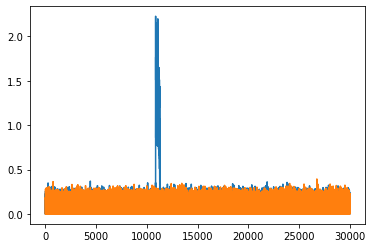

In [14]:
plt.plot(raw_t, raw_d[:, 0,:,0])

The following function will allow us apply the Bold monitor ex-post.

In [15]:
def replay_monitor(raw_d, sim):
    """ Assumes that the raw_d was produced in consistency with the simulator used."""
    assert len(sim.monitors) == 1, "Only one monitor at a time can be replayed."    
    res = [out for out in [ sim.monitors[0].record(step, sim.model.observe(state)) for step, state in enumerate(raw_d)] if out is not None]
    b_t, b_d = zip(*res)
    b_t, b_d = np.array(b_t), np.array(b_d)
    return b_t, b_d

In [16]:
sim = simulator.Simulator(
    model = models.MontbrioPazoRoxin(variables_of_interest=['r']),
    connectivity = conn,
    integrator = integrators.HeunStochastic(
        dt = 0.01, 
        noise = noise.Additive(nsig=np.r_[0.01,0.02])
    ),
    initial_conditions=np.zeros( (1,2,N,1) ),
    stimulus=stimulus,
    monitors=[monitors.BoldBalloonWindkessel(period=10., V0=0.02, tau_s=0.65, alpha=0.32, include_svars=True)],

).configure()


/home/izaak/local_repos/megaloceros/tvb/scientific_library/tvb/simulator/monitors.py:1147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return numpy.array([k1, k2, k3])


In [17]:
b_t, b_d = replay_monitor(raw_d, sim)

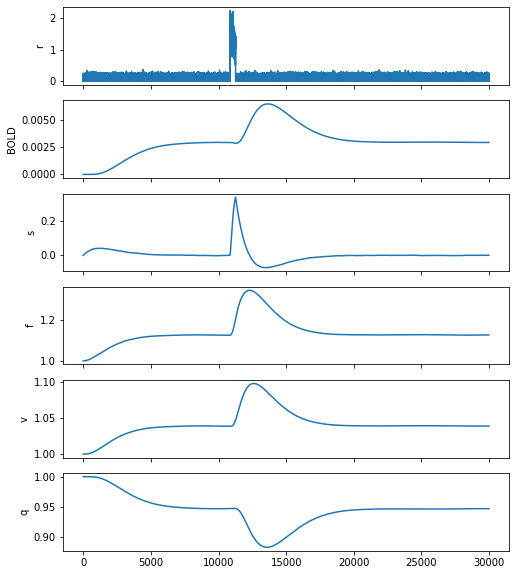

In [18]:
fig, axs = plt.subplots(nrows=6, sharex=True, figsize=(8,10))
axs[0].plot(raw_t,raw_d[:,0,0,0])
axs[0].set(ylabel='r')
for i, (ax, label) in enumerate( zip(axs[1:], ['BOLD', 's', 'f', 'v', 'q'])):
    ax.plot(b_t[:], b_d[:,i,0,0])
    ax.set(ylabel=label)